# Automated ML

TODO: Import Dependencies. In the cell below, import all the dependencies that you will need to complete the project.
Other assumptions include, running Python3.8 kernal and downloading config.json file into current folder.

In [1]:
from azureml.core import Workspace, Experiment, Dataset
from azureml.core.compute import ComputeTarget, AmlCompute
import pandas as pd
from matplotlib import pyplot as plt
from azureml.train.automl import AutoMLConfig
from azureml.widgets import RunDetails

from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.model import Model


## Dataset

### Overview
TODO: In this markdown cell, give an overview of the dataset you are using. Also mention the task you will be performing.


TODO: Get data. In the cell below, write code to access the data you will be using in this project. Remember that the dataset needs to be external.

##### Setting up the dataset

In [2]:
datasource = "https://raw.githubusercontent.com/xrubio/ecologyStamps/master/data/stamps.csv"

data = pd.read_csv(datasource, sep=';')
data.head(5)

,X,Y,id,lat,long,type,site,code,name
0,-0.580500,44.840439,7326,-0.580500,44.840439,Oberaden 74,Bordeaux,PHILODAMVS,Aquitania
1,2.174100,41.398371,33256,2.174100,41.398371,Dressel 2-4 Catalan,Barcelona,O,Tarraconensis
2,4.032143,46.926780,20958,4.032143,46.926780,Dressel 1,Mont-Beuvray,SIN,Lugdunensis
3,-3.983333,55.950000,16637,-3.983333,55.950000,Dressel 20,Cumbernauld,PQ,Caledonia
4,11.883333,45.416667,33025,11.883333,45.416667,Dressel 6B,Padova,LAEK,Italia


From viewing the first few lines of data, I notice that columns X and y are redundant with lat and long.  Additionally 'name' denotes the name of a Roman province, which would be more clear by renaming the column to 'province.'  Finally, I will filter the dataset to only include Dressel-20 vessels. 
TODO reason 

In [3]:
data = data.copy()[data['type']=="Dressel 20"]
data.drop(labels=['X', 'Y', 'type'], axis=1, inplace=True)  #no longer need type, since all vessels same
data.rename(columns={"name":"province"}, inplace=True)
data.head(10)

,id,lat,long,site,code,province
3,16637,-3.983333,55.950000,Cumbernauld,PQ,Caledonia
5,16590,-1.983333,51.733333,Cirencester,CPCAMO,Britannia
8,39655,4.860743,45.531592,Saint-Romain-en-Gal,CSEMPRONIPOLYCLITI,Narbonensis
11,8764,6.807625,47.449211,Mandeure,EVRI,Germania Superior
14,27985,8.645835,50.159548,Nida-Heddernheim,LIVNIMELISSI,Germania Superior
15,27413,8.846132,49.897382,Dieburg,ACIRGI,Germania Superior
18,28359,-5.020370,37.810702,Almodóvar del Río,LIBERALINI,Baetica
19,39634,4.873453,45.524785,Vienne,CSP,Narbonensis
21,14260,6.685037,51.198071,Neuss,ENNIORVMIVLIORVM,Germania Inferior
29,15497,1.333333,51.283333,Edinburgh,ACIRGI,Britannia


In [4]:
print(data[['province', 'id']].groupby(by='province', sort=True, dropna=True).size())

province
Achaia                     6
Aegyptus                  74
Africa Proconsularis       1
Aquitania                163
Asia                       5
Baetica                 1510
Belgica                  353
Britannia               1845
Caledonia                133
Corsica et Sardinia       17
Dalmatia                  15
Germania Inferior        415
Germania Superior       2121
Italia                   476
Lugdunensis              591
Lusitania                 17
Mauretania Tingitana     287
Narbonensis             1807
Noricum                    6
Pannonia Inferior         21
Pannonia Superior          8
Raetia                   136
Syria                      1
Tarraconensis            230
dtype: int64


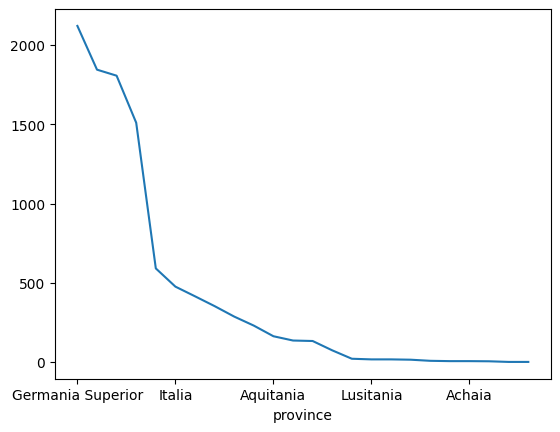

In [5]:
data[['province', 'id']].groupby(by='province', sort=True, dropna=True).size().sort_values(ascending=False).plot()

Something about skewedness of data.  Makes sense, but also needs to be in consideration for the ML job. 

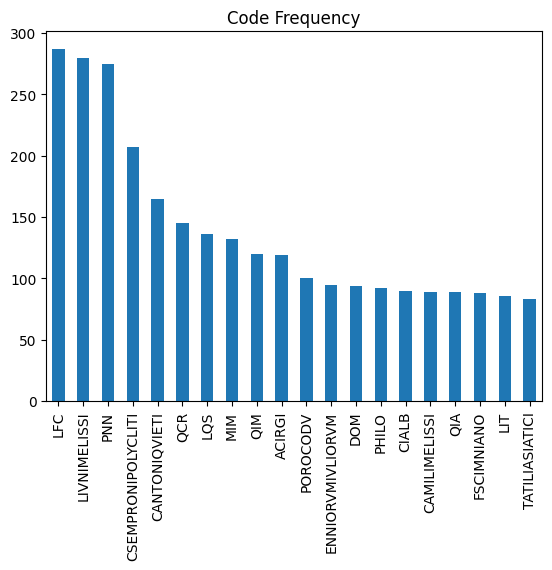

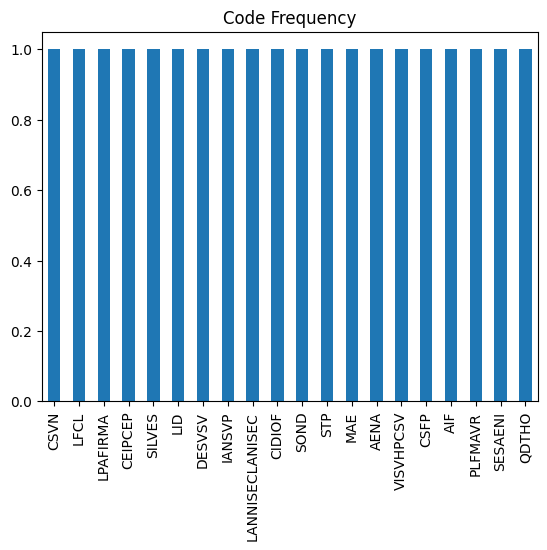

In [6]:
#xplore data distribution
data['code'].value_counts()[0:20].plot(kind='bar', title='Code Frequency')
plt.show()
data['code'].value_counts()[-20:].plot(kind='bar', title='Code Frequency')
plt.show()

Something about single-use stamps not being super interesting or fair/viable to predict.  For the case of this experiment, I will filter to only stamps which are known to occur atleast 20 times. 

In [7]:
data['occurances'] = data.groupby('code')['code'].transform('size')
data = data[data['occurances']>= 20]
data.drop(columns=['occurances'], inplace=True)

In [8]:
#set up workspace and experiment
ws = Workspace.from_config()

# choose a name for experiment
experiment_name = 'stamp_classification'

experiment=Experiment(ws, experiment_name)

In [9]:
#set up compute
from azureml.core.compute import ComputeTarget, AmlCompute

cluster_name = "stampCluster"
nodes = 6
vm_sz = "Standard_D3_V2"

# Verify that cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing cluster, use it.')
except:
    compute_config = AmlCompute.provisioning_configuration(vm_size=vm_sz,
                                                            max_nodes=nodes)
    cpu_cluster = ComputeTarget.create(ws, cluster_name, compute_config)
    cpu_cluster.wait_for_completion(show_output=True)

InProgress.....
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## AutoML Configuration

TODO: Explain why you chose the automl settings and cofiguration you used below.

In [10]:
# TODO: Put your automl settings here
y = 'code'  
metric = 'accuracy'  
timeout_hrs = 3.5  
max_iter = 5  

tabular_data = Dataset.Tabular.register_pandas_dataframe(dataframe=data, name="stamps", target=ws.get_default_datastore())

automl_settings = {
     "task":"classification",  #to determine stamp 
     "primary_metric":metric,  #true accuracy
     "training_data": tabular_data, 
     "label_column_name":y,
    # "n_cross_validations": cvs, not specifing allows monte carlo validation
     "featurization": "auto",  #allow featurization
     "max_concurrent_iterations":max_iter,  #ensure experiment is performant by limiting number of max concurrent iterations
     "iteration_timeout_minutes":25,  #limit time intensive models 
     "experiment_timeout_hours": timeout_hrs,  #limit experiment based environment constraints
     "enable_early_stopping": True,  #allow early termination of poor performing jobs
     "model_explainability": True,
     "compute_target": cluster_name
}

# TODO: Put your automl config here
automl_config = AutoMLConfig(**automl_settings)

Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/7e87c75e-e918-4c7c-893e-b656c71c8f6e/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.


In [11]:
# TODO: Submit your experiment
remote_run = experiment.submit(automl_config)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
stamp_classification,AutoML_36fd77db-0e03-4774-be25-38b2826e460a,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


## Run Details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

TODO: In the cell below, use the `RunDetails` widget to show the different experiments.

In [12]:
remote_run.get_details()
RunDetails(remote_run).show()
remote_run.wait_for_completion(show_output=False)

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

{'runId': 'AutoML_36fd77db-0e03-4774-be25-38b2826e460a',
 'target': 'stampCluster',
 'status': 'Completed',
 'startTimeUtc': '2024-02-07T16:23:27.415365Z',
 'endTimeUtc': '2024-02-07T16:58:03.466384Z',
 'services': {},
 'warnings': [{'source': 'JasmineService',
   'message': 'No scores improved over last 10 iterations, so experiment stopped early. This early stopping behavior can be disabled by setting enable_early_stopping = False in AutoMLConfig for notebook/python SDK runs.'}],
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'stampCluster',
  'AMLSettingsJsonString': '{"path":null,"name":"stamp_classification","subscription_id":"1b944a9b-fdae-4f97-aeb1-b7eea0beac53","resource_group":"aml-quickstarts-252011","workspace_name":"quick-starts-ws-252011","region":"southcentralus","compute_target":"stampC

## Best Model

TODO: In the cell below, get the best model from the automl experiments and display all the properties of the model.



In [15]:
#TODO: Save the best model
results = remote_run.get_best_child()
metrics = results.get_metrics()
best_run = results.get_details().get('runID')

print('The best run was: ')
print(results)
print('The best run reported the following metrics: ')
print(metrics)

The best run was: 
Run(Experiment: stamp_classification,
Id: AutoML_36fd77db-0e03-4774-be25-38b2826e460a_38,
Type: azureml.scriptrun,
Status: Completed)
The best run reported the following metrics: 
{'precision_score_macro': 0.5523194979829444, 'average_precision_score_weighted': 0.5927111070833074, 'balanced_accuracy': 0.5155612158536257, 'AUC_weighted': 0.8650948319127764, 'f1_score_macro': 0.518382676356877, 'average_precision_score_macro': 0.48761055130711517, 'recall_score_micro': 0.6079988537099276, 'average_precision_score_micro': 0.5938059670137866, 'precision_score_micro': 0.6079988537099276, 'precision_score_weighted': 0.6167459803000839, 'matthews_correlation': 0.5991081777869411, 'f1_score_weighted': 0.6023508793365505, 'AUC_macro': 0.8320683238896606, 'recall_score_macro': 0.5155612158536257, 'f1_score_micro': 0.6079988537099276, 'log_loss': 2.3059559099656552, 'recall_score_weighted': 0.6079988537099276, 'weighted_accuracy': 0.7057293249414726, 'norm_macro_recall': 0.5098

In [14]:
#get full details of best run
print(results.get_details())

{'runId': 'AutoML_36fd77db-0e03-4774-be25-38b2826e460a_38', 'target': 'stampCluster', 'status': 'Completed', 'startTimeUtc': '2024-02-07T16:55:43.093337Z', 'endTimeUtc': '2024-02-07T16:57:56.834395Z', 'services': {}, 'properties': {'runTemplate': 'automl_child', 'pipeline_id': '__AutoML_Ensemble__', 'pipeline_spec': '{"pipeline_id":"__AutoML_Ensemble__","objects":[{"module":"azureml.train.automl.ensemble","class_name":"Ensemble","spec_class":"sklearn","param_args":[],"param_kwargs":{"automl_settings":"{\'task_type\':\'classification\',\'primary_metric\':\'accuracy\',\'verbosity\':20,\'ensemble_iterations\':15,\'is_timeseries\':False,\'name\':\'stamp_classification\',\'compute_target\':\'stampCluster\',\'subscription_id\':\'1b944a9b-fdae-4f97-aeb1-b7eea0beac53\',\'region\':\'southcentralus\',\'spark_service\':None}","ensemble_run_id":"AutoML_36fd77db-0e03-4774-be25-38b2826e460a_38","experiment_name":"stamp_classification","workspace_name":"quick-starts-ws-252011","subscription_id":"1b94

## Model Deployment

Remember you have to deploy only one of the two models you trained but you still need to register both the models. Perform the steps in the rest of this notebook only if you wish to deploy this model.

TODO: In the cell below, register the model, create an inference config and deploy the model as a web service.

In [14]:
#register the model
model_name = 'StampsAutoML'

r_model = remote_run.register_model(model_name = model_name, description = 'The best autoML model')


In [15]:
#deploy the model

#results.get_properties()
env = results.get_environment()
scoring = results.get_properties().get('scoring_data_location')

results.download_file('outputs/scoring_file_v_1_0_0.py', 'scoring.py')
name = 'stampmodel'

#or here we dont enable authentication!!!!
inference_config = InferenceConfig(entry_script='scoring.py', environment=env)
deployment_config = AciWebservice.deploy_configuration(cpu_cores = 1,
                                                       memory_gb = 4,
                                                       description = 'Stamps',
                                                       #auth_enabled=True,
                                                       enable_app_insights = True,
                                                       collect_model_data=True)
service = Model.deploy(ws, name, [r_model], inference_config, deployment_config, overwrite=True)
service.wait_for_deployment(show_output=True)
                                   


Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2024-02-07 06:40:29+00:00 Creating Container Registry if not exists.
2024-02-07 06:40:29+00:00 Registering the environment.
2024-02-07 06:40:29+00:00 Use the existing image.
2024-02-07 06:40:30+00:00 Submitting deployment to compute.
2024-02-07 06:40:36+00:00 Checking the status of deployment stampmodel..
2024-02-07 06:44:34+00:00 Checking the status of inference endpoint stampmodel.
Succeeded
ACI service creation operation finished, operation "Succeeded"


TODO: In the cell below, send a request to the web service you deployed to test it.

In [16]:
#check deployment

print('Swagger URI:', service.swagger_uri)
print('Score URI', service.scoring_uri)
service.state

Swagger URI: http://04431a52-d9ab-4a80-a053-0dcab5aaa30c.westus2.azurecontainer.io/swagger.json
Score URI http://04431a52-d9ab-4a80-a053-0dcab5aaa30c.westus2.azurecontainer.io/score


'Healthy'

In [26]:
#get data from original dataset to test endpoint
import json
test_data = data.drop(columns=['code']).sample(n=1).to_dict("records")
json_fil = {
    "data": test_data,
}

testdataformat = json.dumps(json_fil)
#print(testdataformat)
display(test_data)

[{'id': 13493,
  'lat': -5.666942,
  'long': 37.615058,
  'site': 'Alcolea del Río',
  'province': 'Baetica'}]

In [24]:
import requests
headers = {"Content-Type": "application/json"}
response = requests.post(service.scoring_uri, testdataformat, headers=headers)
#print(response)
print(response.json())

{"result": ["CAMILIMELISSI", "ACIRGI", "PHILO", "TATILIASIATICI", "IICCLLM"]}


In [25]:
print(service.get_logs())

2024-02-07T06:44:23,431474400+00:00 - rsyslog/run 
2024-02-07T06:44:23,442250100+00:00 - gunicorn/run 
2024-02-07T06:44:23,444571500+00:00 | gunicorn/run | 
2024-02-07T06:44:23,450240100+00:00 | gunicorn/run | ###############################################
2024-02-07T06:44:23,452154900+00:00 | gunicorn/run | AzureML Container Runtime Information
2024-02-07T06:44:23,459047200+00:00 - nginx/run 
2024-02-07T06:44:23,460219300+00:00 | gunicorn/run | ###############################################
2024-02-07T06:44:23,473826800+00:00 | gunicorn/run | 
2024-02-07T06:44:23,486772000+00:00 | gunicorn/run | 
2024-02-07T06:44:23,502065900+00:00 | gunicorn/run | AzureML image information: openmpi4.1.0-ubuntu20.04, Materializaton Build:20230628.v2
2024-02-07T06:44:23,514112900+00:00 | gunicorn/run | 
2024-02-07T06:44:23,525870600+00:00 | gunicorn/run | 
2024-02-07T06:44:23,532159900+00:00 | gunicorn/run | PATH environment variable: /azureml-envs/azureml-automl/bin:/opt/miniconda/bin:/usr/local/sbi

In [20]:
service.delete()
model.delete()
compute_target.delete()

**Submission Checklist**
- I have registered the model.
- I have deployed the model with the best accuracy as a webservice.
- I have tested the webservice by sending a request to the model endpoint.
- I have deleted the webservice and shutdown all the computes that I have used.
- I have taken a screenshot showing the model endpoint as active.
- The project includes a file containing the environment details.
